## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').count()[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("group == 'treatment' and landing_page == 'old_page'").count()[0] + df.query("group == 'control' and landing_page == 'new_page'").count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No, none of the rows have missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query("group == 'control' and landing_page == 'old_page'")

In [9]:
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

user_id 773192

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop([2893], inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.query('converted == "1"').count()[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
converted_old = df2.query("group == 'control' and converted == '1'").count()[0]/df2.query("group == 'control'").count()[0]
converted_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
converted_new = df2.query("group == 'treatment' and converted == '1'").count()[0]/df2.query("group == 'treatment'").count()[0]
converted_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

There is no evidence that one age leads to a higher number of conversions than another. The number of converted users in the control group is very similar to the number of converted users in the treatment group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
H0 = conversion rate new  - conversion rate old > 0
H1 = conversion rate new - conversion rate old <= 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [63]:
diffs = []
new_crs = []
old_crs = []
size = df2.shape[0]

In [64]:
for __ in range(10000):
    bootsamp = df2.sample(size, replace=True)
    new_df = bootsamp.query('landing_page == "new_page"')
    old_df = bootsamp.query('landing_page == "old_page"')
    new_cr = new_df.query('converted == "1"').count()[0]/new_df.count()[0]
    old_cr = old_df.query('converted == "1"').count()[0]/old_df.count()[0]
    new_crs.append(new_cr)
    old_crs.append(old_cr)
    diffs.append(new_cr - old_cr)

a. What is the **convert rate** for $p_{new}$ under the null? 
0.1196 - same as the convert rate as the converted rate in ab_data.csv

In [65]:
diffs = np.array(diffs)

In [66]:
null_vals = np.random.normal(0, diffs.std(), diffs.size)

In [67]:
new_crs = np.array(new_crs)

In [68]:
new_crs.mean()

0.11880485439062459

b. What is the convert rate for  p old  under the null?
0.1196- same as the convert rate as the converted rate in ab_data.csv

In [69]:
old_crs = np.array(old_crs)
old_crs.mean()

0.12037422499711491

c. What is $n_{new}$?

In [20]:
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
p_new = df2.query('converted == "1"').count()[0]/df2.shape[0] 
new_page_convert = np.random.choice([0,1],n_new, p=(1-p_new, p_new))

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
p_old = df2.query('converted == "1"').count()[0]/df2.shape[0]
old_page_convert = np.random.choice([0,1], n_old, p=(1-p_old, p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_convert.mean() - old_page_convert.mean()

0.00011484343889618664

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
    sample = df2.sample(size, replace=True)
    new_page_converted = np.random.choice([0,1],n_new, p=(1-p_new, p_new))
    old_page_converted = np.random.choice([0,1],n_old, p=(1-p_old, p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Yes, it is a normal distribution as expected.

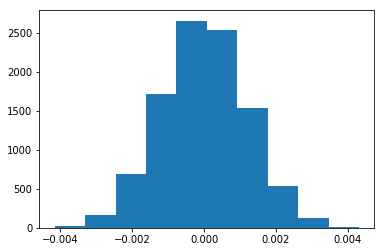

In [27]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = converted_new - converted_old

In [29]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

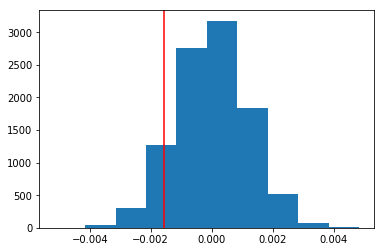

In [30]:
#Plot null distribution
plt.hist(null_vals)
plt.axvline(x=obs_diff,color ='red');

In [31]:
(null_vals > obs_diff).mean()

0.9073

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value computed above is the p-value. Because the p-value is greater than .05, we fail to reject the null hypothesis and decide that is not evidence of a difference between new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [81]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
n_old
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [82]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [83]:
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

A z-score over 1.95 or under -1.95 would indicate significance for a one tailed test. Because the z-score is -1.31, we once again fail to reject the null hypothesis.

The p-value is large (0.905) and indicates that we fail to reject the null.

These results agree with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [84]:
#add intercept column
df2['intercept'] = 1

#add dummy variable column for which page each user received
df2_dummies = pd.get_dummies(df2['landing_page'])
df2 = df2.join(df2_dummies)

#add ab_page column
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [85]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [86]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        15:20:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.190. The null hypothesis associated with the regression model is that there is no difference in conversion rates between groups, while the alternative hypothesis is that there is a difference in conversion rates between groups. The p-value is different than Part II because the alternative hypothesis in Part II is that the treatment group would have a higher conversion rate than the control rate.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Time of day, gender of the individual, and age of the individual could all be factors that might influence whether an individual converts. One disadvantage to adding additional terms to the regression model is that it will make interpreting the model more difficult. Another disadvantage is potential multicollinearity, that is if the new variables are dependent on each other.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [87]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [88]:
df_countries = df2.merge(df_countries, on ='user_id', how='left')
df_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US


In [89]:
#determine unique countries
df_countries['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [90]:
#create dummy variables
df_countries[['US', 'CA', 'UK']] = pd.get_dummies(df_countries['country'])
#use 'US' as baseline
df_countries = df_countries.drop(df_countries['US'])
#add intercept
df_countries['intercept'] = 1

In [91]:
#create logit regression
logit_countries = sm.Logit(df_countries['converted'], df_countries[['intercept','new_page','CA','UK']])
result = logit_countries.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 May 2018   Pseudo R-squ.:               2.325e-05
Time:                        15:21:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1757
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.248      0.000      -2.082      -1.978
new_page      -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA             0.0506      0.028      1.784      0.075      -0.005       0.106
UK             0.0408      0.027      1.516      0.129      -0.012       0.093
==============================================================================
"""

In [98]:
#exponentiate variables attached to explanatory variable
np.exp(result.params)

intercept    0.131333
new_page     0.985152
CA           1.051944
UK           1.041611
dtype: float64

In [107]:
1/np.exp(result.params)

intercept    7.614244
new_page     1.015071
CA           0.950621
UK           0.960052
dtype: float64

New page- conversion is 1.015 times more likely to to occur if an individual is shown the new page rather than the old page, all else constant.

CA- An individual from CA is 1.05 times more likely to convert than an individual from the US, all else constant.

UK- An individual from the UK is 1.04 times more likely to convert than an individual from the US, all else constant.

However, in all of these cases the p-value is higher than 0.05, which indicates it is not statistically significant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [108]:
#Create interaction columns 
df_countries['CA_new'] = df_countries['new_page']* df_countries['CA']
df_countries['UK_new'] = df_countries['new_page']* df_countries['UK']

In [109]:
#Fit new model
logit_new_countries = sm.Logit(df_countries['converted'], df_countries[['intercept','new_page','CA_new','UK_new','CA','UK']])
result_countries_new = logit_new_countries.fit()
result_countries_new.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            5
Date:                Wed, 23 May 2018   Pseudo R-squ.:               3.484e-05
Time:                        15:24:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1917
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page      -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA_new         0.0783      0.057      1.378      0.168      -0.033       0.190
UK_new         0.0469      0.054      0.871      0.384      -0.059       0.152
CA             0.0118      0.040      0.296      0.767      -0.066       0.090
UK             0.0176      0.038      0.466      0.641      -0.056       0.091
==============================================================================
"""

In [110]:
#exponentiate variables attached to explanatory variable
np.exp(result_countries_new.params)

intercept    0.134794
new_page     0.934776
CA_new       1.081428
UK_new       1.047978
CA           1.011854
UK           1.017705
dtype: float64

Considering the high p-values, none of the variables are statistically significant. This indicates that the country an individual resides in and the page the individual uses together are not statistically significant.

Results:
A user in CA with the new page is 1.08 times more likely to convert than a user in the US with the new page

A user in the UK with the new page is 1.05 times more likely to convert than a user in the US with the new page.


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [32]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0